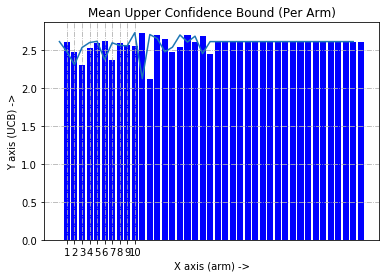

/home/anubha/.local/lib/python3.6/site-packages/ipykernel_launcher.py:153: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


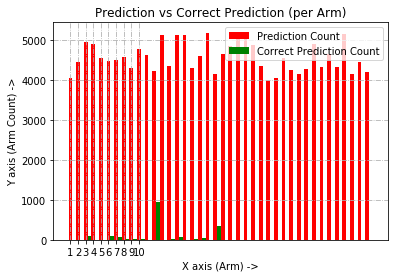

NameError: name 'CTR' is not defined

In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Created on Sat Mar 17 19:31:32 2018

COMS 6998-2: Advanced Machine Learning for Personalization
Homework 2: Contextual bandit algorithm using disjoint LinUCB

@author: Apoorv Purwar (ap3644)
"""

import numpy as np
import matplotlib.pylab as plt

# Global Variables
__input_file__ = "dataset.txt"
__context_size__ = 58
__arm_size__ = 40


# Function to calculate the Cummulative Take Rate
def calc_CTR(reward, ctr_num, ctr_den):

    # Keeps a count of CTR and updates the numerator and denominator on every correct call
    ctr_num = ctr_num + reward
    ctr_den = ctr_den + 1

    ctr = ctr_num/ctr_den

    return ctr, ctr_num, ctr_den


# linUCB Algorithm
def linUCB(data, __alpha__):

    # Dictionary to store CTR at every time step
    CTR = {}

    # Declare the coefficient, upper confidence bound dictionary and the other dictionaries
    # used for plotting the various graphs
    coeff = {}
    ucb = {}
    ucb_mean = {}
    arm_pred = {}
    correct_pred = {}

    # Declare dictionaries A and b
    A = {}
    b = {}
    for arm in range(0,__arm_size__):
        # Initialize matrix A and b for each arm, with dimension as 100 which is the size of context
        A[arm] = np.identity(__context_size__)    # dimension 100 * 100
        b[arm] = np.atleast_2d(np.zeros(__context_size__)).T # dimension 100 * 1

        # Initialize UCBs as 0 for all arms
        ucb[arm] = 0

        # Initialize arm prediction for each arm - to plot it later
        arm_pred[arm] = 0
        correct_pred[arm] = 0
        ucb_mean[arm] = 0

    # Initiate time, predicted arm and numerator and denominators of CTR
    time = 1
    ctr_num = 0
    ctr_den = 0

    # Iterate over all 10,000 data point
    for index,row in data.iterrows():

        # Fetch individual values to perform operations on them
        values = row.tolist()

        # Convert all strings in the list to integer
#         values = list(map(int, values))

        # Get the Arm - which is the action performed
        curr_arm = values.pop(3)

        # Get reward for the current action
#         reward = values.pop(0)
        reward =1

        # Create the context array
        context = np.asarray(values)

        # Loop to update coefficient and calculate pay off for each arm
        for arm in range(0,__arm_size__):
            # Calculate the coefficent, standard deviation and UCB for the arm
            coeff[arm] = np.dot(np.linalg.inv(A[arm]), b[arm])
            standard_deviation = np.sqrt(np.dot(context.T, np.dot(np.linalg.inv(A[arm]), context)))

            # Method 1 - Prediction count dependent alpha
            if(__alpha__ == -1):
                denom = 0.001/((correct_pred[arm]+1)/10)
                ucb[arm] = np.asscalar(np.dot(coeff[arm].T, context) + np.dot(denom, standard_deviation))
            elif(__alpha__ == 0):
                # Method 2 - Time Dependent Alpha
                ucb[arm] = np.asscalar(np.dot(coeff[arm].T, context) + np.dot((1/time**0.5), standard_deviation))
            else:
                # Method 3 - Constant Alpha
                ucb[arm] = np.asscalar(np.dot(coeff[arm].T, context) + np.dot(__alpha__, standard_deviation))

            ucb_mean[arm] += ucb[arm]

        # Choose the arm with largest UCB
        pred_arm = np.argmax(list(ucb.values())) + 1

        # Count of Predicted Arm
        arm_pred[curr_arm] += 1

        # If the prediction matches the current arm, calculate CTR and update values
        if(curr_arm == pred_arm):
            # Update matrix A and B
            A[curr_arm] = A[curr_arm] + np.outer(context, context)
            b[curr_arm] = b[curr_arm] + reward * np.reshape(context,(58,1))
            # Call calculate CTR function
            curr_CTR, ctr_num, ctr_den = calc_CTR(reward, ctr_num, ctr_den)
            # Store the CTR at current time stamp
            CTR[time] = curr_CTR
            correct_pred[curr_arm] += 1


        # Increment the time step
        time += 1

    # *****   LinUCB Algorithm Ends and Graph Plotting begins here   *****
    # Calculate the mean UCB for each arm
    for arm in range(0,__arm_size__ ):
        ucb_mean[arm] = ucb_mean[arm]/time

    # ********* Mean UCB Plot *********
    lists = sorted(ucb_mean.items())
    x, y = zip(*lists)
    plt.plot(x, y, label = 'Standard Deviation')
    plt.bar(np.arange(len(ucb_mean)) + 1, list(ucb_mean.values()), align='center', color = 'b', label = 'UCB')
    ax = plt.gca()
    ax.set_xlabel('X axis (arm) ->')
    ax.set_ylabel('Y axis (UCB) ->')
    ax.set_title('Mean Upper Confidence Bound (Per Arm)')
    ax.grid(True, linestyle='-.')
    ax.set_xticks(np.arange(1, 11, 1))
    plt.show()

    # ********* Arm Prediction Plot *********
    ax = plt.subplot(1,1,1)
    width = 0.5
    ax.bar(np.arange(len(arm_pred)) + 1, list(arm_pred.values()), width = width, align='center', color = 'r', label = 'Prediction Count')
    ax.bar(np.arange(len(correct_pred)) + 1 + width, list(correct_pred.values()), width = width, align='center', color = 'g', label = 'Correct Prediction Count')
    ax.legend()

    ax = plt.subplot(1,1,1)
    ax.set_xlabel('X axis (Arm) ->')
    ax.set_ylabel('Y axis (Arm Count) ->')
    ax.set_title('Prediction vs Correct Prediction (per Arm)')
    ax.grid(True, linestyle='-.')
    ax.set_xticks(np.arange(1, 11, 1))
    plt.show()

    return CTR,correct_pred,arm_pred


# Function to plot the combined CTR graphs
def plotCTR(CTR, CTR1, CTR2, CTR3):

    lists = sorted(CTR.items())
    x, y = zip(*lists) # unpack a list of pairs into two tuples

    lists = sorted(CTR1.items())
    x1, y1 = zip(*lists)

    lists = sorted(CTR2.items())
    x2, y2 = zip(*lists)

    lists = sorted(CTR3.items())
    x3, y3 = zip(*lists)

    p1 = plt.plot(x, y, label = 'alpha = 0.001', color = 'b')
    p2 = plt.plot(x1, y1, label = 'alpha = 1', color = 'r')
    p3 = plt.plot(x2, y2, label = 'alpha = 1/sqrt(t)', color = 'g')
    p4 = plt.plot(x3, y3, label = 'alpha = 0.001/(0.1*Prediction Count)', color = 'm')

    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    ax.set_xlabel('X axis (time steps) ->')
    ax.set_ylabel('Y axis (CTR) ->')
    ax.set_title('Contextual Bandit Learning for Different alpha values')
    ax.grid(True, linestyle='-.')
    ax.set_yticks(np.arange(0, 1, 0.1))
    plt.show()


# Main driver function
if __name__ == "__main__":

#     # Fetch the data from the file
#     with open(__input_file__,"r") as file:
#         # Strip the new line character from the end of each line
#         data = [line.strip("\n") for line in file]
    data = df_new
    # Call linUCB Algorithm for different alpha values
#     CTR,correct_pred,arm_pred = linUCB(data, 0.001)
    CTR1 = linUCB(data, 1)
    # 0 and -1 alpha values here just hand the time and arm dependent cases
#     CTR2 = linUCB(data, 0)
#     CTR3 = linUCB(data, -1)

    #  ********** Plot the combined CTR Graphs **********
    print (CTR1,correct_pred,arm_pred)
#     return correct_pred,arm_pred, CTR
#     plotCTR(CTR, CTR1, CTR2, CTR3)


In [5]:
correct_pred

NameError: name 'correct_pred' is not defined

In [26]:
arm_pred

{0: 4055,
 1: 4445,
 2: 4945,
 3: 4885,
 4: 4541,
 5: 4467,
 6: 4493,
 7: 4574,
 8: 4301,
 9: 4782,
 10: 4620,
 11: 4216,
 12: 5131,
 13: 4350,
 14: 5129,
 15: 5114,
 16: 4302,
 17: 4589,
 18: 5178,
 19: 4145,
 20: 4642,
 21: 4849,
 22: 5132,
 23: 5055,
 24: 4876,
 25: 4346,
 26: 3966,
 27: 4053,
 28: 4539,
 29: 4253,
 30: 4140,
 31: 4276,
 32: 4885,
 33: 4332,
 34: 4648,
 35: 4333,
 36: 5147,
 37: 4138,
 38: 4438,
 39: 4184}

In [ ]:
#DATASET CLEANING

In [28]:
CTR

{14: 1.0,
 20: 1.0,
 2737: 1.0,
 4372: 1.0,
 4402: 1.0,
 4481: 1.0,
 4548: 1.0,
 4657: 1.0,
 4750: 1.0,
 5496: 1.0,
 5710: 1.0,
 6015: 1.0,
 6329: 1.0,
 6339: 1.0,
 6387: 1.0,
 6399: 1.0,
 6400: 1.0,
 6415: 1.0,
 6443: 1.0,
 6542: 1.0,
 6595: 1.0,
 6616: 1.0,
 6632: 1.0,
 6633: 1.0,
 6697: 1.0,
 6731: 1.0,
 6771: 1.0,
 6779: 1.0,
 6853: 1.0,
 7037: 1.0,
 7226: 1.0,
 7303: 1.0,
 7311: 1.0,
 7386: 1.0,
 7404: 1.0,
 7584: 1.0,
 7684: 1.0,
 7821: 1.0,
 7869: 1.0,
 7891: 1.0,
 7901: 1.0,
 8115: 1.0,
 8173: 1.0,
 8194: 1.0,
 8270: 1.0,
 8283: 1.0,
 8334: 1.0,
 8378: 1.0,
 8419: 1.0,
 8462: 1.0,
 8506: 1.0,
 8578: 1.0,
 8603: 1.0,
 8663: 1.0,
 8674: 1.0,
 8910: 1.0,
 9113: 1.0,
 9185: 1.0,
 9214: 1.0,
 9256: 1.0,
 9491: 1.0,
 9842: 1.0,
 9981: 1.0,
 9987: 1.0,
 10506: 1.0,
 10599: 1.0,
 10636: 1.0,
 10947: 1.0,
 11977: 1.0,
 12040: 1.0,
 12168: 1.0,
 12187: 1.0,
 12231: 1.0,
 12250: 1.0,
 12356: 1.0,
 12399: 1.0,
 12414: 1.0,
 12453: 1.0,
 12466: 1.0,
 12530: 1.0,
 12767: 1.0,
 12963: 1.0,
 1

In [1]:
import pandas as pd
df=pd.read_csv('news_dataset_last_40_encoded.csv')

In [2]:
df.head()

,user_id,session_id,session_start,session_size,click_timestamp,click_region,created_at_ts,words_count,article_id,category_26,...,click_country_9,click_country_10,click_country_11,click_referrer_type_1,click_referrer_type_2,click_referrer_type_3,click_referrer_type_4,click_referrer_type_5,click_referrer_type_6,click_referrer_type_7
0,278760,1507738846274401,1507738846000,2,1507740326434,5,1507633764000,175,29953,1,...,0,0,0,1,0,0,0,0,0,0
1,2522,1507678682105944,1507678682000,14,1507688543249,21,1507633764000,175,29953,1,...,0,0,0,1,0,0,0,0,0,0
2,27768,1507678812218062,1507678812000,4,1507679608544,9,1507633764000,175,29953,1,...,0,0,0,1,0,0,0,0,0,0
3,30545,1507678889494130,1507678889000,2,1507679382763,16,1507633764000,175,29953,1,...,0,0,0,1,0,0,0,0,0,0
4,114574,1507679057319269,1507679057000,5,1507679399082,25,1507633764000,175,29953,1,...,0,0,0,1,0,0,0,0,0,0


In [3]:
df_new =df.drop(columns=['user_id','session_id','session_start','click_timestamp','created_at_ts'])

In [4]:
df_new = df_new.sample(frac=1)

In [6]:
def preprocess(df):
    from sklearn.preprocessing import minmax_scale

    df[['session_size','click_region','words_count']] = minmax_scale(df[['session_size','click_region','words_count']])
    return df

In [9]:
from sklearn.preprocessing import LabelEncoder
df_new = preprocess(df_new)
le = LabelEncoder()
df_new['article_id'] =le.fit_transform(df_new['article_id'])

In [12]:
df_new.to_csv('final_news_dataset.csv',index =None)

In [20]:
np.amax(df_new['article_id'])

39

In [3]:
import pandas as pd
df_new = pd.read_csv('final_news_dataset.csv')

In [1]:
df = df.drop(columns=['timestamp'])

NameError: name 'df' is not defined